In [1]:
from __future__ import print_function
import numpy as np
import datetime

In [2]:
np.random.seed(1337)  # for reproducibility

In [3]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import tensorflow as tf  ## this is a quick fix added to to the code
import matplotlib.pyplot as plt

/Users/iris/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
now = datetime.datetime.now

In [5]:
print(now())

2018-09-16 10:44:51.398646


In [6]:
batch_size = 32  # can be changed 
nb_classes = 5  # 5,6,7,8,9
nb_epoch = 50  # how many times to run through the full set of examples

# input image dimensions
img_rows, img_cols = 28, 28  # pixles

# number of convolutional filters to use
nb_filters = 32  # capacity to learn 32 features
# size of pooling area for max pooling
pool_size = 2.
# convolution kernel size
kernel_size = 3

In [7]:
print(K.image_dim_ordering())

tf


In [8]:
if K.image_dim_ordering() == 'th':
    input_shape = (1, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 1)

In [9]:
def train_model(model, train, test, nb_classes, nb_epoch=nb_epoch):
    global hist
    X_train = train[0].reshape((train[0].shape[0],) + input_shape)
    X_test = test[0].reshape((test[0].shape[0],) + input_shape)
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255 #  X_train =  X_train / 255
    X_test /= 255
    print('X_train shape:', X_train.shape)
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    Y_train = np_utils.to_categorical(train[1], nb_classes)#exa 7 = [0,0,1,0,0]
    Y_test = np_utils.to_categorical(test[1], nb_classes)

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])
                  
    t = now()
    hist = model.fit(X_train, Y_train,
              batch_size=batch_size, nb_epoch=nb_epoch,verbose=1, validation_data=(X_test, Y_test))
    print('Training time: %s' % (now() - t))
    score = model.evaluate(X_test, Y_test, verbose=0)
    #s0, s1 = score[0],score[1] 
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

In [10]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [11]:
X_test.shape, X_train.shape

((10000, 28, 28), (60000, 28, 28))

In [12]:
X_train_lt5  = X_train[y_train < 5]
y_train_lt5  = y_train[y_train < 5]
X_test_lt5   = X_test[y_test < 5]
y_test_lt5   = y_test[y_test < 5]

X_train_gte5 = X_train[y_train >= 5]
y_train_gte5 = y_train[y_train >= 5] - 5  # make classes start at 0 for ##indexing
X_test_gte5  = X_test[y_test >= 5]         # np_utils.to_categorical
y_test_gte5  = y_test[y_test >= 5] - 5

In [13]:
nex = 64
X_train_5 = X_train[y_train == 5]
X_train_5 = X_train_5[:nex]
X_train_6 = X_train[y_train == 6]
X_train_6 = X_train_6[:nex]
X_train_7 = X_train[y_train == 7]
X_train_7 = X_train_7[:nex]
X_train_8 = X_train[y_train == 8]
X_train_8 = X_train_8[:nex]
X_train_9 = X_train[y_train == 9]
X_train_9 = X_train_9[:nex]
X_train_gte5_n50 = np.concatenate((X_train_5, X_train_6, X_train_7, X_train_8, X_train_9))

In [14]:
ind = np.arange(0, X_train_gte5_n50.shape[0])
np.random.shuffle(ind)
X_train_gte5_n50 = X_train_gte5_n50[ind]
y_train_gte5_n50 = np.tile([0, 1, 2, 3, 4], (nex, 1))
y_train_gte5_n50 = y_train_gte5_n50.flatten('F')
y_train_gte5_n50 = y_train_gte5_n50[ind]

In [15]:
feature_layers = [
    Convolution2D(nb_filters, kernel_size, kernel_size,
                  border_mode='valid',
                  input_shape=input_shape),
    Activation('relu'),
    Convolution2D(nb_filters, kernel_size, kernel_size),
    Activation('relu'),
    MaxPooling2D(pool_size=(pool_size, pool_size)),
    Dropout(0.25),
    Flatten(),
]
classification_layers = [
    Dense(128),
    Activation('relu'),
    Dropout(0.5),
    Dense(nb_classes),
    Activation('softmax')
]

/Users/iris/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(28, 28, 1..., padding="valid")`
  after removing the cwd from sys.path.
/Users/iris/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
  


In [16]:
feature_layers[1]

In [17]:
model = Sequential()
model.add(Convolution2D (filters = 32,kernel_size =(3,3),input_shape = (28,28,1),activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Convolution2D (filters = 32,kernel_size =(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(output_dim = 128 , activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_dim = nb_classes , activation="softmax"))
#model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy']) # b/c we have a binary output we use loss = 'binary_crossentropy'

/Users/iris/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  if __name__ == '__main__':
/Users/iris/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5)`
  # This is added back by InteractiveShellApp.init_path()


In [18]:
train_model(model, (X_train_lt5, y_train_lt5), (X_test_lt5, y_test_lt5), nb_classes, nb_epoch=nb_epoch)

X_train shape: (30596, 28, 28, 1)
30596 train samples
5139 test samples


/Users/iris/anaconda2/envs/py36/lib/python3.6/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 30596 samples, validate on 5139 samples
Epoch 1/50
30596/30596 [==============================] - 20s 649us/step - loss: 0.1220 - acc: 0.9614 - val_loss: 0.0181 - val_acc: 0.9949
Epoch 2/50
30596/30596 [==============================] - 19s 606us/step - loss: 0.0449 - acc: 0.9865 - val_loss: 0.0123 - val_acc: 0.9967
Epoch 3/50
30596/30596 [==============================] - 18s 605us/step - loss: 0.0341 - acc: 0.9893 - val_loss: 0.0098 - val_acc: 0.9977
Epoch 4/50
30596/30596 [==============================] - 19s 611us/step - loss: 0.0280 - acc: 0.9916 - val_loss: 0.0085 - val_acc: 0.9975
Epoch 5/50
30596/30596 [==============================] - 19s 618us/step - loss: 0.0244 - acc: 0.9924 - val_loss: 0.0066 - val_acc: 0.9979
Epoch 6/50
30596/30596 [==============================] - 19s 624us/step - loss: 0.0210 - acc: 0.9933 - val_loss: 0.0066 - val_acc: 0.9975
Epoch 7/50
30596/30596 [==============================] - 19s 623us/step - loss: 0.0211 - acc: 0.9937 - val_loss: 0.0

In [19]:
import json
d = hist.history
json.dump(d, open("text_0_4_B32.txt",'w'))

In [20]:
filename = "weights_training_0_4_B32.hdf5"
model.save_weights(filename,overwrite=True)

In [21]:
fname = "weights_training_0_4_B32.hdf5"
model.load_weights(fname)

train_model(model,(X_train_gte5_n50, y_train_gte5_n50),(X_test_gte5, y_test_gte5), nb_classes, nb_epoch=nb_epoch)

X_train shape: (320, 28, 28, 1)
320 train samples
4861 test samples


/Users/iris/anaconda2/envs/py36/lib/python3.6/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 320 samples, validate on 4861 samples
Epoch 1/50
320/320 [==============================] - 1s 4ms/step - loss: 4.5767 - acc: 0.3844 - val_loss: 1.6556 - val_acc: 0.4758
Epoch 2/50
320/320 [==============================] - 1s 3ms/step - loss: 1.3491 - acc: 0.5406 - val_loss: 0.9460 - val_acc: 0.6799
Epoch 3/50
320/320 [==============================] - 1s 3ms/step - loss: 0.9345 - acc: 0.7281 - val_loss: 0.7048 - val_acc: 0.7665
Epoch 4/50
320/320 [==============================] - 1s 3ms/step - loss: 0.7242 - acc: 0.7750 - val_loss: 0.5888 - val_acc: 0.8050
Epoch 5/50
320/320 [==============================] - 1s 3ms/step - loss: 0.5865 - acc: 0.8313 - val_loss: 0.4917 - val_acc: 0.8420
Epoch 6/50
320/320 [==============================] - 1s 3ms/step - loss: 0.4334 - acc: 0.8406 - val_loss: 0.4284 - val_acc: 0.8636
Epoch 7/50
320/320 [==============================] - 1s 3ms/step - loss: 0.4402 - acc: 0.8750 - val_loss: 0.3901 - val_acc: 0.8725
Epoch 8/50
320/320 [=========

In [22]:
import json
d = hist.history
json.dump(d, open("text_5_9_A32.txt",'w'))

In [23]:
for k in feature_layers:
    print(k.trainable)
    k.trainable = False

# train_model(model, train, test, nb_classes, nb_epoch=nb_epoch):
train_model(model,(X_train_gte5_n50, y_train_gte5_n50),(X_test_gte5, y_test_gte5), nb_classes, nb_epoch=nb_epoch)

True
True
True
True
True
True
True
X_train shape: (320, 28, 28, 1)
320 train samples
4861 test samples


/Users/iris/anaconda2/envs/py36/lib/python3.6/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 320 samples, validate on 4861 samples
Epoch 1/50
320/320 [==============================] - 1s 4ms/step - loss: 0.0282 - acc: 0.9938 - val_loss: 0.2151 - val_acc: 0.9414
Epoch 2/50
320/320 [==============================] - 1s 3ms/step - loss: 0.0256 - acc: 0.9938 - val_loss: 0.2235 - val_acc: 0.9385
Epoch 3/50
320/320 [==============================] - 1s 4ms/step - loss: 0.0215 - acc: 0.9938 - val_loss: 0.2278 - val_acc: 0.9410
Epoch 4/50
320/320 [==============================] - 1s 3ms/step - loss: 0.0440 - acc: 0.9844 - val_loss: 0.2218 - val_acc: 0.9414
Epoch 5/50
320/320 [==============================] - 1s 3ms/step - loss: 0.0208 - acc: 0.9906 - val_loss: 0.2171 - val_acc: 0.9399
Epoch 6/50
320/320 [==============================] - 1s 3ms/step - loss: 0.0315 - acc: 0.9844 - val_loss: 0.2349 - val_acc: 0.9370
Epoch 7/50
320/320 [==============================] - 1s 3ms/step - loss: 0.0233 - acc: 0.9969 - val_loss: 0.2113 - val_acc: 0.9430
Epoch 8/50
320/320 [=========

In [24]:
import json
d = hist.history
json.dump(d, open("text_5_9_A32_Freezing_layers.txt",'w'))

In [25]:
import json
with open('text_0_4_B32.txt') as json_data:
    data_lte_4 = json.load(json_data)
with open('text_5_9_A32.txt') as json_data:
    data_gte_5_saved_weights = json.load(json_data)

with open('text_5_9_A32_Freezing_layers.txt') as json_data:
    data_gte_5_Freezed_feature_layers = json.load(json_data)

In [26]:
training_accuracy_lth_4    = data_lte_4['acc']
validation_accuracy_lth_4  = data_lte_4['val_acc']

training_loss_lth_4    = data_lte_4['loss']
validation_loss_lth_4  = data_lte_4['val_loss']

training_accuracy_gte_5_saved_weights    = data_gte_5_saved_weights['acc']
validation_accuracy_gte_5_saved_weights  = data_gte_5_saved_weights['val_acc']

training_loss_gte_5_saved_weights    = data_gte_5_saved_weights['loss']
validation_loss_gte_5_saved_weights  = data_gte_5_saved_weights['val_loss']

training_accuracy_gte_5_Freezed_feature_layers    =  data_gte_5_Freezed_feature_layers ['acc']
validation_accuracy_gte_5_Freezed_feature_layers  =  data_gte_5_Freezed_feature_layers ['val_acc']

training_loss_gte_5_Freezed_feature_layers    =  data_gte_5_Freezed_feature_layers ['loss']
validation_loss_gte_5_Freezed_feature_layers  =  data_gte_5_Freezed_feature_layers ['val_loss']

In [27]:
%matplotlib inline

Text(0.5,1,'Loss 0-4 digits')

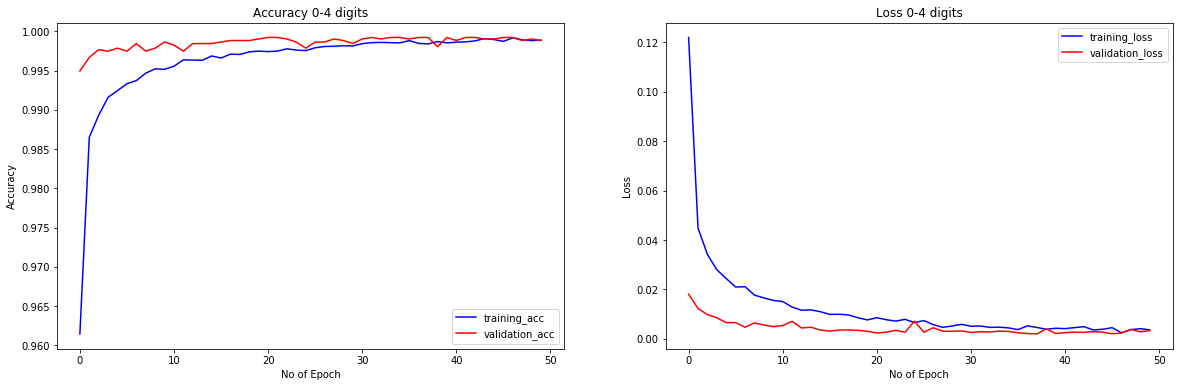

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,6))

axes[0].plot(training_accuracy_lth_4,'b')
axes[0].plot(validation_accuracy_lth_4,'r')
axes[0].legend(['training_acc', 'validation_acc'])
axes[0].set_xlabel('No of Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title("Accuracy 0-4 digits")

axes[1].plot(training_loss_lth_4,'b')
axes[1].plot(validation_loss_lth_4,'r')
axes[1].legend(['training_loss', 'validation_loss'])
axes[1].set_xlabel('No of Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title("Loss 0-4 digits")

Text(0.5,1,'Loss 5-9 digits using saved weight')

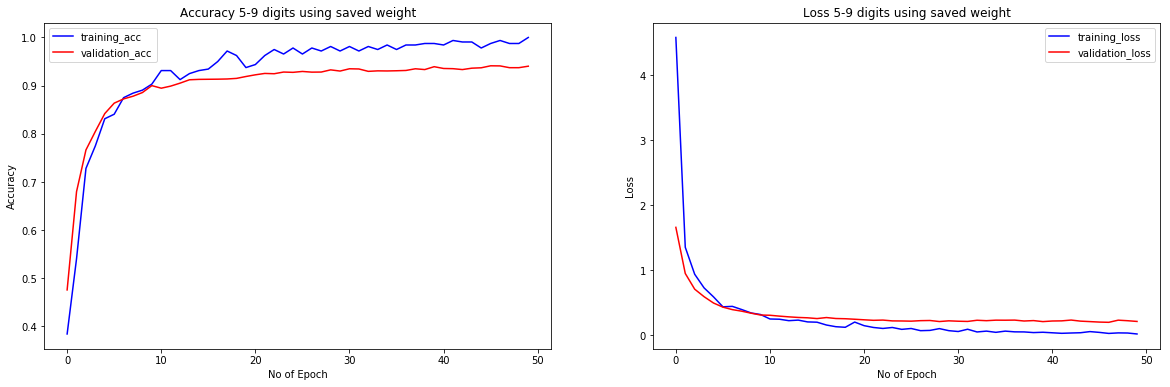

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,6))

axes[0].plot(training_accuracy_gte_5_saved_weights,'b')
axes[0].plot(validation_accuracy_gte_5_saved_weights,'r')
axes[0].legend(['training_acc', 'validation_acc'])
axes[0].set_xlabel('No of Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title("Accuracy 5-9 digits using saved weight")

axes[1].plot(training_loss_gte_5_saved_weights,'b')
axes[1].plot(validation_loss_gte_5_saved_weights,'r')
axes[1].legend(['training_loss', 'validation_loss'])
axes[1].set_xlabel('No of Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title("Loss 5-9 digits using saved weight")

Text(0.5,1,' Loss 5-9 digits using freezed feature layers')

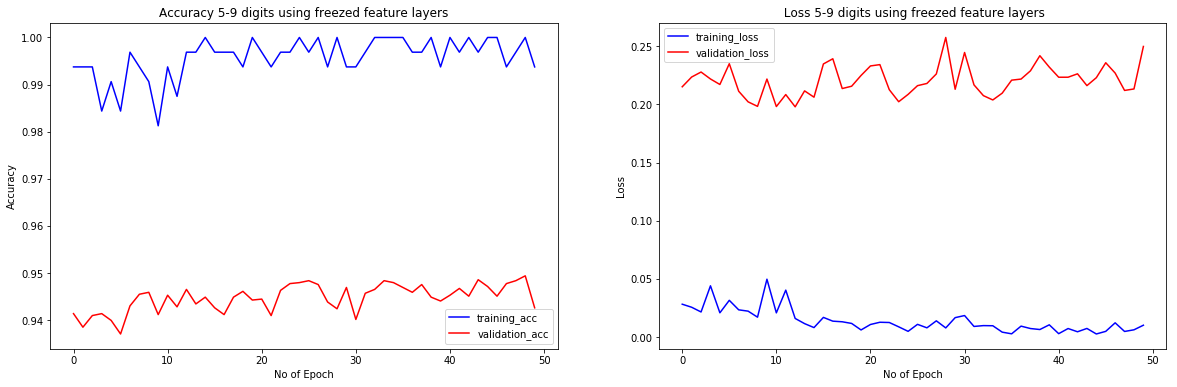

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,6))

axes[0].plot(training_accuracy_gte_5_Freezed_feature_layers,'b')
axes[0].plot(validation_accuracy_gte_5_Freezed_feature_layers,'r')
axes[0].legend(['training_acc', 'validation_acc'])
axes[0].set_xlabel('No of Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title("Accuracy 5-9 digits using freezed feature layers")

axes[1].plot(training_loss_gte_5_Freezed_feature_layers,'b')
axes[1].plot(validation_loss_gte_5_Freezed_feature_layers,'r')
axes[1].legend(['training_loss', 'validation_loss'])
axes[1].set_xlabel('No of Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title(" Loss 5-9 digits using freezed feature layers")

In [31]:
print('Accuracy on Digits [0-4]',training_accuracy_lth_4[-1])
print('Accuracy on Digits [5-9]',training_accuracy_gte_5_saved_weights[-1])
print('Accuracy on Digits [5-9]',training_accuracy_gte_5_Freezed_feature_layers[-1])

Accuracy on Digits [0-4] 0.9988887436266178
Accuracy on Digits [5-9] 1.0
Accuracy on Digits [5-9] 0.99375


In [32]:
print('Accuracy on Digits [0-4]',validation_accuracy_lth_4[-1])
print('Accuracy on Digits [5-9]',validation_accuracy_gte_5_saved_weights[-1])
print('Accuracy on Digits [5-9]',validation_accuracy_gte_5_Freezed_feature_layers[-1])

Accuracy on Digits [0-4] 0.9988324576765908
Accuracy on Digits [5-9] 0.9403414935198519
Accuracy on Digits [5-9] 0.9426044023863402
